In [2]:
#from tensorflow.python.summary.summary_iterator import summary_iterator
import tensorflow as tf
import numpy as np
import pandas as pd
import collections
import glob
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from tqdm import tqdm, tqdm_notebook
import json
import yaml
import warnings
import torch
import torch.utils.data
import copy
import mnist

from networks import WeightLearningNetwork
from learning import train, test
from datasets import load_preprocessed_mnist
import utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [59]:
def subplots_xlabel(axes, label, is_row=False, is_col=False):
    if is_row:
        for ax in axes:
            ax.set_xlabel(label)
    elif is_col:
        axes[-1].set_xlabel(label)
    else:  # grid
        for ax in axes[-1]:
            ax.set_xlabel(label)
        
def subplots_ylabel(axes, label, is_row=False, is_col=False):
    if is_row:
        axes[0].set_ylabel(label)
    elif is_col:
        for ax in axes:
            ax.set_ylabel(label)
    else:  # grid
        for ax in axes[:, 0]:
            ax.set_ylabel(label)

In [60]:
def read_tensorboard(out_dir, num_steps=None):
    """
    Read all tensorboard files from out_dir (and its subdirs) and return their scalars as pandas data frames.
    
    Args:
        out_dir (str): The output directory (e.g. created by utils.init_output).
        num_steps (int, optional): The number of steps to read. If None, read the entire file. 
            Set this if the file shows a truncated error (default: None).
    
    Returns:
        None if no tensorboard file was found, a pandas data frame if a single file was found, 
        and a list of pandas data frames if multiple files were found. 
    """
    
    # Find tensorboard event files in out_dir and its subdirs.
    event_filenames = glob.glob(os.path.join(out_dir, '*', 'event*'))
    dfs = []
    
    for event_filename in event_filenames:
        
        # Make iterator object from event file and limit the number of steps to read.
        iterator = tf.train.summary_iterator(event_filename)
        #if num_steps is not None:
        #    iterator = itertools.islice(iterator, num_steps)
        
        # Go through iterator, write values and steps to dicts.
        values = collections.defaultdict(list)
        steps = collections.defaultdict(list)
        for event in iterator:
            #print(event)
            if event.step > num_steps-1:
                break
            for value in event.summary.value:
                values[value.tag].append(value.simple_value)
                steps[value.tag].append(event.step)

        # Find the maximum step. 
        max_step = max(max(s) for s in steps.values())

        # Write everything to dataframe. 
        df = pd.DataFrame(columns=values.keys(), index=range(max_step+1))
        for key in values:
            df[key][steps[key]] = values[key]

        dfs.append(df)
        
    if len(dfs) == 0:
        return None
    elif len(dfs) == 1:
        return dfs[0]
    else:
        return dfs
    
#df = read_tensorboard("../aws-synced-out/2019-12-12_22-30-50")
#df.head()

In [68]:
def evaluate_randomly_mutated_network(params, num_connections):
    """Create a network by randomly mutating it until it has num_connections connections, 
    train it on the dataset and return its test accuracy.  """

    # Create initial network.
    train_only_outputs = (params['train_only_outputs'] or params['learning_rule'] == 'hebbian')
    use_random_feedback = (params['learning_rule'] == 'feedback_alignment')
    net = WeightLearningNetwork(params['num_inputs'], params['num_outputs'],
                                params['p_initial_connection_enabled'],
                                p_add_connection=params['p_add_connection'],
                                p_add_node=params['p_add_node'],
                                inherit_weights=params['inherit_weights'],
                                train_only_outputs=train_only_outputs,
                                use_random_feedback=use_random_feedback,
                                add_only_hidden_connections=True)

    # Add some nodes manually at the beginning (just like in run-wlnn-mnist.py).
    for _ in range(net.get_num_connections()):
        if np.random.rand() < 0.5:
            net.add_node()

    # Perform random mutations until the network has at least num_connections connections.
    if net.get_num_connections() > num_connections:
        warnings.warn(f'Initial network has more connections ({net.get_num_connections()}) '
                      f'than desired ({num_connections})')
    while net.get_num_connections() < num_connections:
        net.mutate()

    # Train and test the network.
    net.create_torch_layers()
    train(net, train_dataset, params)
    test_loss, test_acc = test(net, test_dataset, params)
    return test_acc

# MNIST

Make an image plot that shows some MNIST images to explain the dataset in the thesis.

In [3]:
train_set = mnist.train_images()

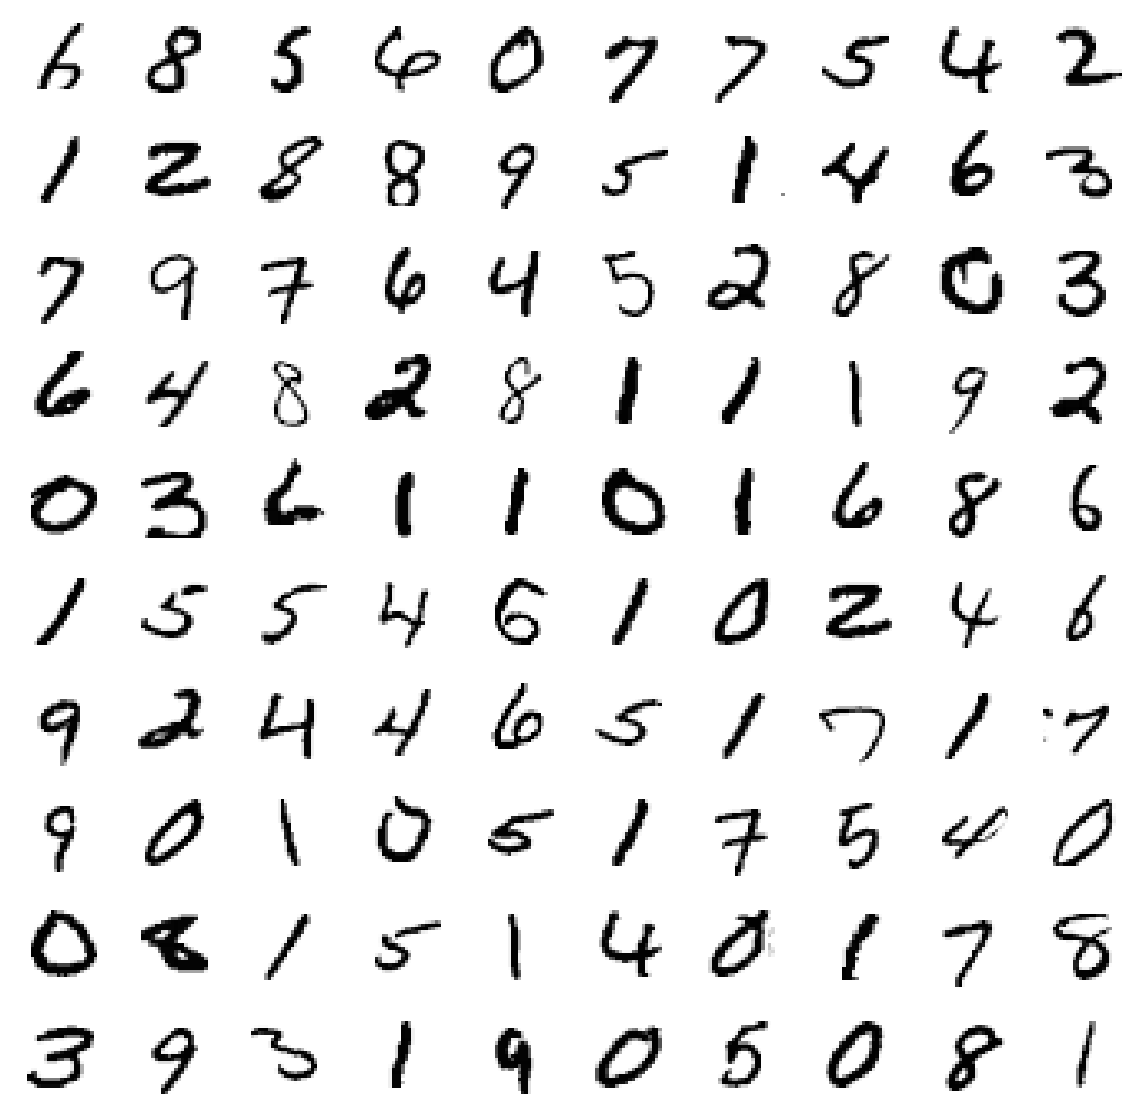

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for ax in axes.flatten():
    plt.sca(ax)
    plt.imshow(train_set[np.random.randint(1000)], cmap='Greys')
    plt.axis('off')

#plt.savefig('figures/mnist.png', dpi=300)

# WANN

In [47]:
df_wann_mnist = read_tensorboard('../final_logs/2019-11-28_23-42-24')
df_wann_swingup = read_tensorboard('../final_logs/2019-11-30_02-34-46')
df_wann_bipedal = read_tensorboard('../final_logs/2019-12-01_22-18-42')

df_backprop = read_tensorboard("../aws-synced-out/2019-12-12_22-30-50")

/Users/jrieke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Learning curves

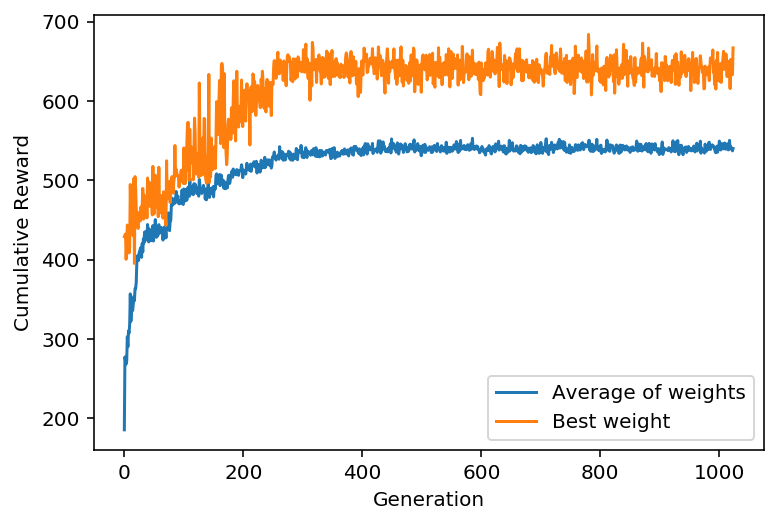

In [67]:
# CartPoleSwingUp. 
# TODO: Add curves for the other runs or standard deviation.
plt.plot(df_wann_swingup.index, df_wann_swingup['best/mean_reward'], '-', label='Average of weights')
plt.plot(df_wann_swingup.index, df_wann_swingup['best/max_reward'], '-', label='Best weight')
plt.xlabel('Generation')
plt.ylabel('Cumulative Reward')
plt.legend()

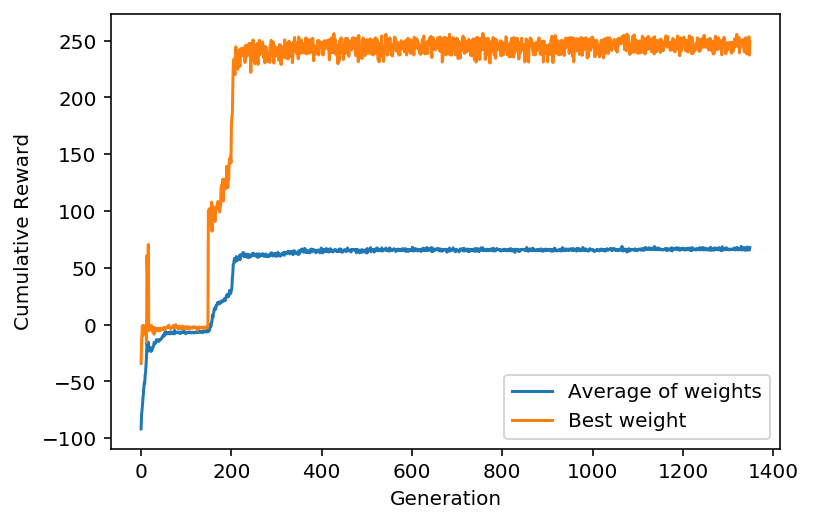

In [68]:
# BipedalWalker-v2.
plt.plot(df_wann_bipedal.index, df_wann_bipedal['best/mean_reward'], '-', label='Average of weights')
plt.plot(df_wann_bipedal.index, df_wann_bipedal['best/max_reward'], '-', label='Best weight')
plt.xlabel('Generation')
plt.ylabel('Cumulative Reward')
plt.legend()

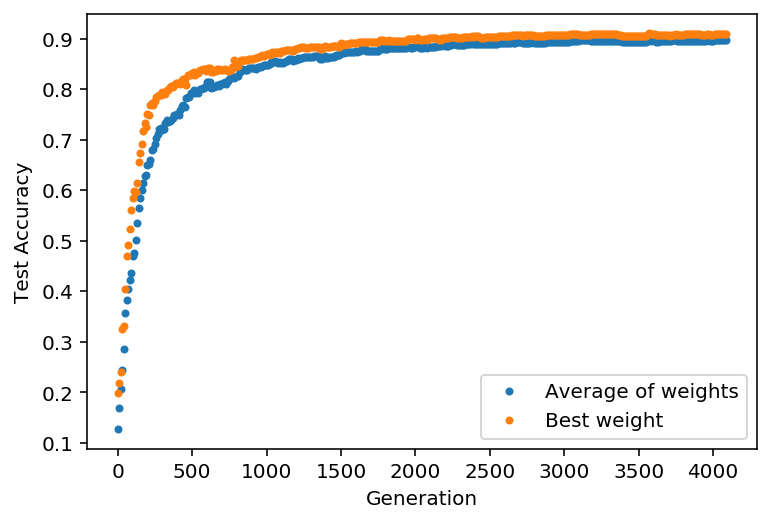

In [69]:
# MNIST.
#mask = np.isfinite(wann_df['champion/max_acc'].astype(float))
plt.plot(wann_df.index, wann_df['champion/mean_acc'], '.', label='Average of weights')
plt.plot(wann_df.index, wann_df['champion/max_acc'], '.', label='Best weight')
plt.xlabel('Generation')
plt.ylabel('Test Accuracy')
plt.legend()

# Learning + evolution

In [8]:
out_dir_dict = {
    'backprop': "../aws-synced-out/2020-01-17_03-13-44",
    'feedback_alignment': "../aws-synced-out/2020-01-17_03-16-56",
    'hebbian': "../aws-synced-out/2020-01-17_03-19-33",
    'last_layer': "../aws-synced-out/2020-01-17_03-22-37"
}

In [5]:
label_dict = {
    'backprop': 'Backpropagation',
    'feedback_alignment': 'Feedback alignment',
    'hebbian': 'Hebbian learning',
    'last_layer': 'Last-layer learning'
}

In [6]:
color_dict = {
    'backprop': 'C0',
    'feedback_alignment': 'C1',
    'hebbian': 'C2',
    'last_layer': 'C3'
}
#colors = ['b', 'r', 'g', 'orange']
#colors = ['C0', 'C3', 'C2', 'C1']

In [61]:
params_dict = {
    'backprop': utils.load_params_file('params/wlnn-mnist/mnist-backprop.yaml'),
    'feedback_alignment': utils.load_params_file('params/wlnn-mnist/mnist-feedback_alignment.yaml'),
    'hebbian': utils.load_params_file('params/wlnn-mnist/mnist-hebbian.yaml'),
    'last_layer': utils.load_params_file('params/wlnn-mnist/mnist-backprop.yaml')
}
# TODO: Make this a separate parameter file.
params_dict['last_layer']['train_only_outputs'] = True

for params in params_dict.values():  # long training as in run-wlnn-mnist script
    params['num_epochs'] = 10

In [66]:
print('Loading dataset...')
train_images, train_labels, test_images, test_labels = load_preprocessed_mnist(
    flatten_images=True, use_torch=True)
train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
print('Done')

Loading dataset...
Done


In [16]:
# Read tensorboard logs.
num_steps = 1000
df_dict = {}
for key, out_dir in out_dir_dict.items():
    print(f'Reading {key} from: {out_dir}')
    df_dict[key] = read_tensorboard(out_dir, num_steps)
    print(f'Read {len(df_dict[key])} steps')
    print()

Reading backprop from: ../aws-synced-out/2020-01-17_03-13-44


/Users/jrieke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Read 772 steps

Reading feedback_alignment from: ../aws-synced-out/2020-01-17_03-16-56
Read 537 steps

Reading hebbian from: ../aws-synced-out/2020-01-17_03-19-33
Read 1000 steps

Reading last_layer from: ../aws-synced-out/2020-01-17_03-22-37
Read 1000 steps



In [75]:
num_randomly_mutated_nets = 20

for key in df_dict:

    print(f'Results for {key}:')
    print()

    last_row = df_dict[key].dropna().iloc[-1]
    print('Found last entry for champion network at generation', last_row.name)
    print(f'Test acc: {last_row["champion/test_acc"]:.5f}')
    # TODO: Write neurons and layers for champion net to tensorboard.
    #print('Neurons:', last_row['champion/neurons'])
    print('Connections:', last_row['champion/connections'])
    print()

    print(f'Evaluating {num_randomly_mutated_nets} randomly mutated networks with {last_row["champion/connections"]} connections...')
    randomly_mutated_accs = [evaluate_randomly_mutated_network(params_dict[key], 
                                                               last_row['champion/connections']) 
                             for _ in range(num_randomly_mutated_nets)]
    randomly_mutated_accs = np.array(randomly_mutated_accs)
    print(f'Test acc: {randomly_mutated_accs.mean():.5f} +- {randomly_mutated_accs.std():.5f} '
          f'(min: {randomly_mutated_accs.min():.5f}, max: {randomly_mutated_accs.max():.5f})')
    print()
    print('-'*80)
    print()



Results for backprop:

Found last entry for champion network at generation 760
Test acc: 0.89884
Connections: 854.0

Evaluating 20 randomly mutated networks with 854.0 connections...
Test acc: 0.78573 +- 0.04113 (min: 0.67758, max: 0.85727)

--------------------------------------------------------------------------------

Results for feedback_alignment:

Found last entry for champion network at generation 520
Test acc: 0.88802
Connections: 1767.0

Evaluating 20 randomly mutated networks with 1767.0 connections...
Test acc: 0.77478 +- 0.05504 (min: 0.64163, max: 0.85477)

--------------------------------------------------------------------------------

Results for hebbian:

Found last entry for champion network at generation 980
Test acc: 0.77464
Connections: 362.0

Evaluating 20 randomly mutated networks with 362.0 connections...
Test acc: 0.48381 +- 0.05985 (min: 0.34946, max: 0.58183)

--------------------------------------------------------------------------------

Results for last_

## Progress during evolution

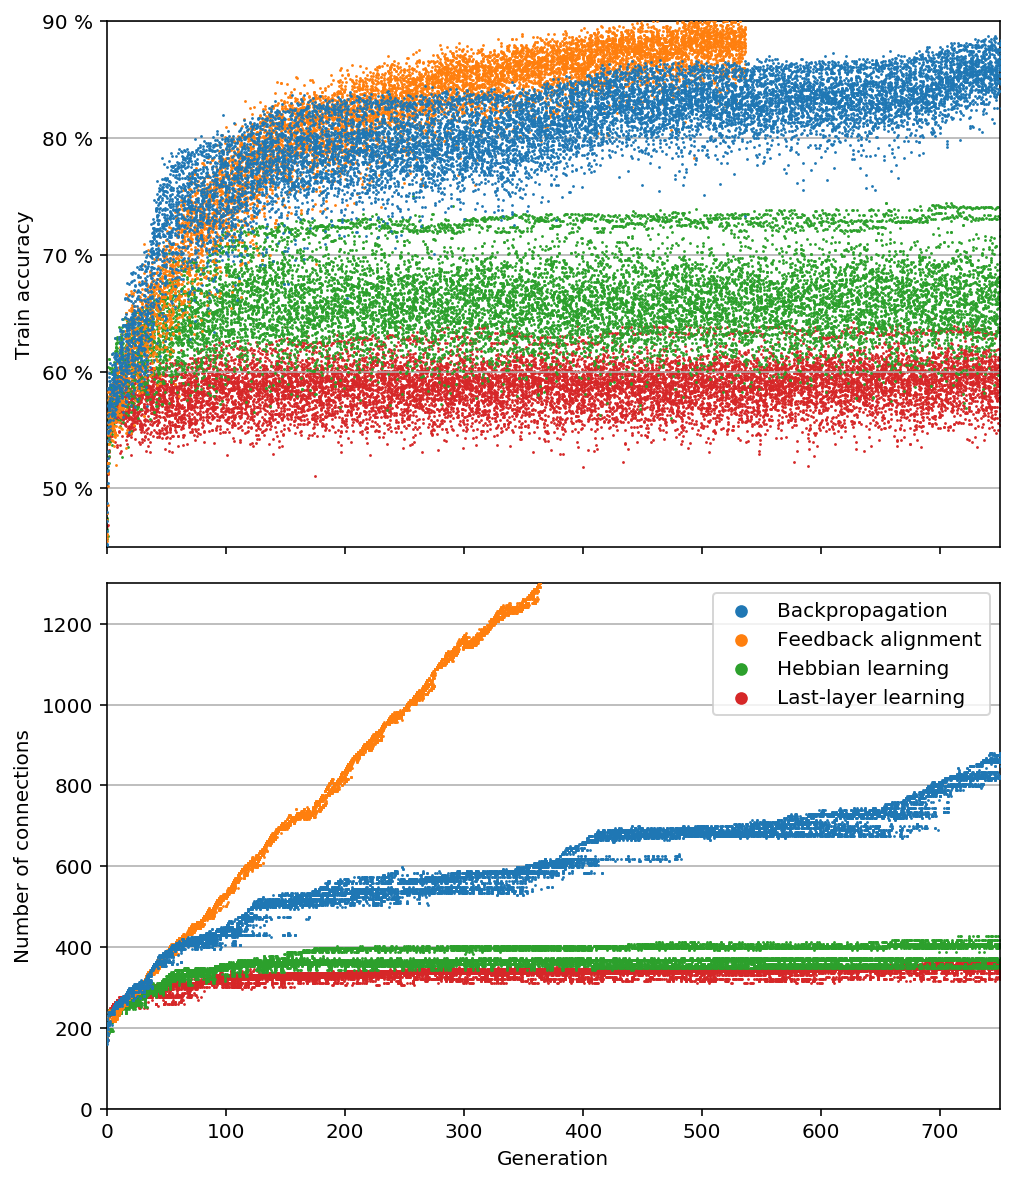

In [26]:
population_size = 180
elements_to_plot = 18

# Use this dict to control which lines are in the foreground and background.
zorders = {
    'backprop': 4,
    'feedback_alignment': 3,
    'hebbian': 2,
    'last_layer': 1
}

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 10), sharex=True)
for key, df in df_dict.items():
    
    # Accuracy plot.
    plt.sca(ax1)
    for i, element in enumerate(np.random.randint(0, population_size, elements_to_plot)):
        plt.scatter(df.index, df[f'population/net{element}_acc'], 
                    color=color_dict[key], s=2, alpha=1, linewidth=0, zorder=zorders[key],
                    label=label_dict[key] if i == 0 else None)
        
    plt.ylabel('Train accuracy')
    plt.ylim(0.45, 0.9)
    plt.xlim(0, 750)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0, symbol=' %'))
    plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
    plt.gca().yaxis.grid(True)
    #legend = plt.legend()
    #for handle in legend.legendHandles:
    #    handle.set_sizes([30])
    
    # Connections plot.
    plt.sca(ax2)
    for i, element in enumerate(np.random.randint(0, population_size, elements_to_plot)):
        plt.scatter(df.index, df[f'population/net{element}_connections'], 
                    color=color_dict[key], s=2, alpha=1, linewidth=0, zorder=zorders[key],
                    label=label_dict[key] if i == 0 else None)

    plt.xlabel('Generation')
    plt.ylabel('Number of connections')
    plt.xlim(0, 750)
    plt.ylim(0, 1300)
    plt.gca().yaxis.grid(True)

    legend = plt.legend()
    for handle in legend.legendHandles:
        handle.set_sizes([40])

plt.subplots_adjust(hspace=0.07)
plt.savefig('figures/evolution.png', dpi=300)

## Comparison to randomly mutated networks and one-hidden-layer networks

In [86]:
# TODO: Finish implementing this once everything else is done. 
def evaluate_one_hidden_layer_network(params, num_connections, num_neurons):
    train_only_outputs = (params['train_only_outputs'] or params['learning_rule'] == 'hebbian')
    use_random_feedback = (params['learning_rule'] == 'feedback_alignment')
    
    net = WeightLearningNetwork(params['num_inputs'], params['num_outputs'],
                                params['p_initial_connection_enabled'],
                                p_add_connection=params['p_add_connection'],
                                p_add_node=params['p_add_node'],
                                inherit_weights=params['inherit_weights'],
                                train_only_outputs=train_only_outputs,
                                use_random_feedback=use_random_feedback,
                                add_only_hidden_connections=True)
    
    if net.get_num_connections() > num_connections:
        warnings.warn(f'Initial network has more connections ({net.get_num_connections()}) '
                      f'than desired ({num_connections})')
        
    print(net.neurons_in_layer)
        
    # TODO: Add hidden layer so that network has all in all num_connections connections and num_neurons neurons.
    num_hidden_neurons = num_neurons - net.num_neurons
    num_connections_before=
    num_hidden_connections = num_connections - net.get_num_connections()
    net.neurons_per_layer.insert(1, list(range(net.num_neurons, net.num_neurons + num_hidden)))
    # net.connections = []  # erase any connections between input and output
    # for from_neuron in net.neurons_per_layer[0]:  # add connections between input and hidden
    #     for to_neuron in net.neurons_per_layer[1]:
    #         net.connections.append([from_neuron, to_neuron])
    # for from_neuron in net.neurons_per_layer[1]:  # add connections between hidden and output
    #     for to_neuron in net.neurons_per_layer[2]:
    #         net.connections.append([from_neuron, to_neuron])
    # net.num_neurons += num_hidden
    # net.reset_weights()  # need to call this manually due to manual changes to architecture
    # logging.info(f'Added a hidden layer with {num_hidden} neurons, network now has {net}')
    
    # Train and test the network.
    net.create_torch_layers()
    train(net, train_dataset, params)
    test_loss, test_acc = test(net, test_dataset, params)
    return test_acc
    
    
evaluate_one_hidden_layer_network(params_dict['backprop'], 300, 300)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

0.577323717948718

In [88]:
# TODO: Calculate this for 10-15 evenly spaced connections values in the range that is shown in each plot.
connection_values = list(range(200, 801, 400))
num_nets = 2

randomly_mutated_network_accs_dict = {}
for key, params in params_dict.items():
    print(f'Evaluating randomly mutated networks for {key}:')
    
    # For each value in connection_values, evaluate num_nets randomly mutated networks 
    # and store their accuracies in an array.
    randomly_mutated_network_accs_dict[key] = np.zeros((len(connection_values), num_nets))
    for i, num_connections in enumerate(tqdm_notebook(connection_values, desc='Connections')):
        for j in tqdm_notebook(range(num_nets), desc='Networks', leave=False):
            randomly_mutated_network_accs_dict[key][i, j] = evaluate_randomly_mutated_network(
                params, num_connections)

Evaluating randomly mutated networks for backprop:


Evaluating randomly mutated networks for feedback_alignment:


/Users/jrieke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Initial network has more connections (217) than desired (200)


Evaluating randomly mutated networks for hebbian:


/Users/jrieke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Initial network has more connections (219) than desired (200)


Evaluating randomly mutated networks for last_layer:


In [45]:
# Store as json.
#with open('randomly_mutated_networks.json', 'w') as f:
#    json.dump({
#        'connection_values': connection_values, 
#        'randomly_mutated_network_accs_dict': {key: arr.tolist() for key, arr 
#                                               in randomly_mutated_network_accs_dict.items()}
#    }, f)

In [77]:
# Load from json.
with open('randomly_mutated_networks.json', 'r') as f:
    j = json.load(f)
    connection_values = j['connection_values']
    randomly_mutated_network_accs_dict = {key: np.array(value) for key, value 
                                          in j['randomly_mutated_network_accs_dict'].items()}
    
connection_values, randomly_mutated_network_accs_dict

([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800],
 {'backprop': array([[0.44731571, 0.41015625, 0.49659455, 0.4838742 , 0.44080529,
          0.50330529, 0.38151042, 0.54226763, 0.45022035, 0.39473157,
          0.43990385, 0.30268429, 0.51121795, 0.48036859, 0.48677885,
          0.46254006, 0.3843149 , 0.47315705, 0.50290465, 0.37820513],
         [0.57612179, 0.38591747, 0.47796474, 0.48818109, 0.54166667,
          0.53094952, 0.49749599, 0.4921875 , 0.56490385, 0.46634615,
          0.37079327, 0.45823317, 0.4697516 , 0.49088542, 0.42678285,
          0.47075321, 0.50841346, 0.44511218, 0.43489583, 0.40094151],
         [0.53125   , 0.41105769, 0.41987179, 0.47065304, 0.52213542,
          0.54987981, 0.54046474, 0.4614383 , 0.48327324, 0.54627404,
          0.56290064, 0.54096554, 0.38421474, 0.42848558, 0.59795673,
          0.38591747, 0.5395633 , 0.52473958, 0.49429087, 0.44891827],
         [0.60857372, 0.59745593, 0.54797676, 0.42718349, 0.45082131,
       

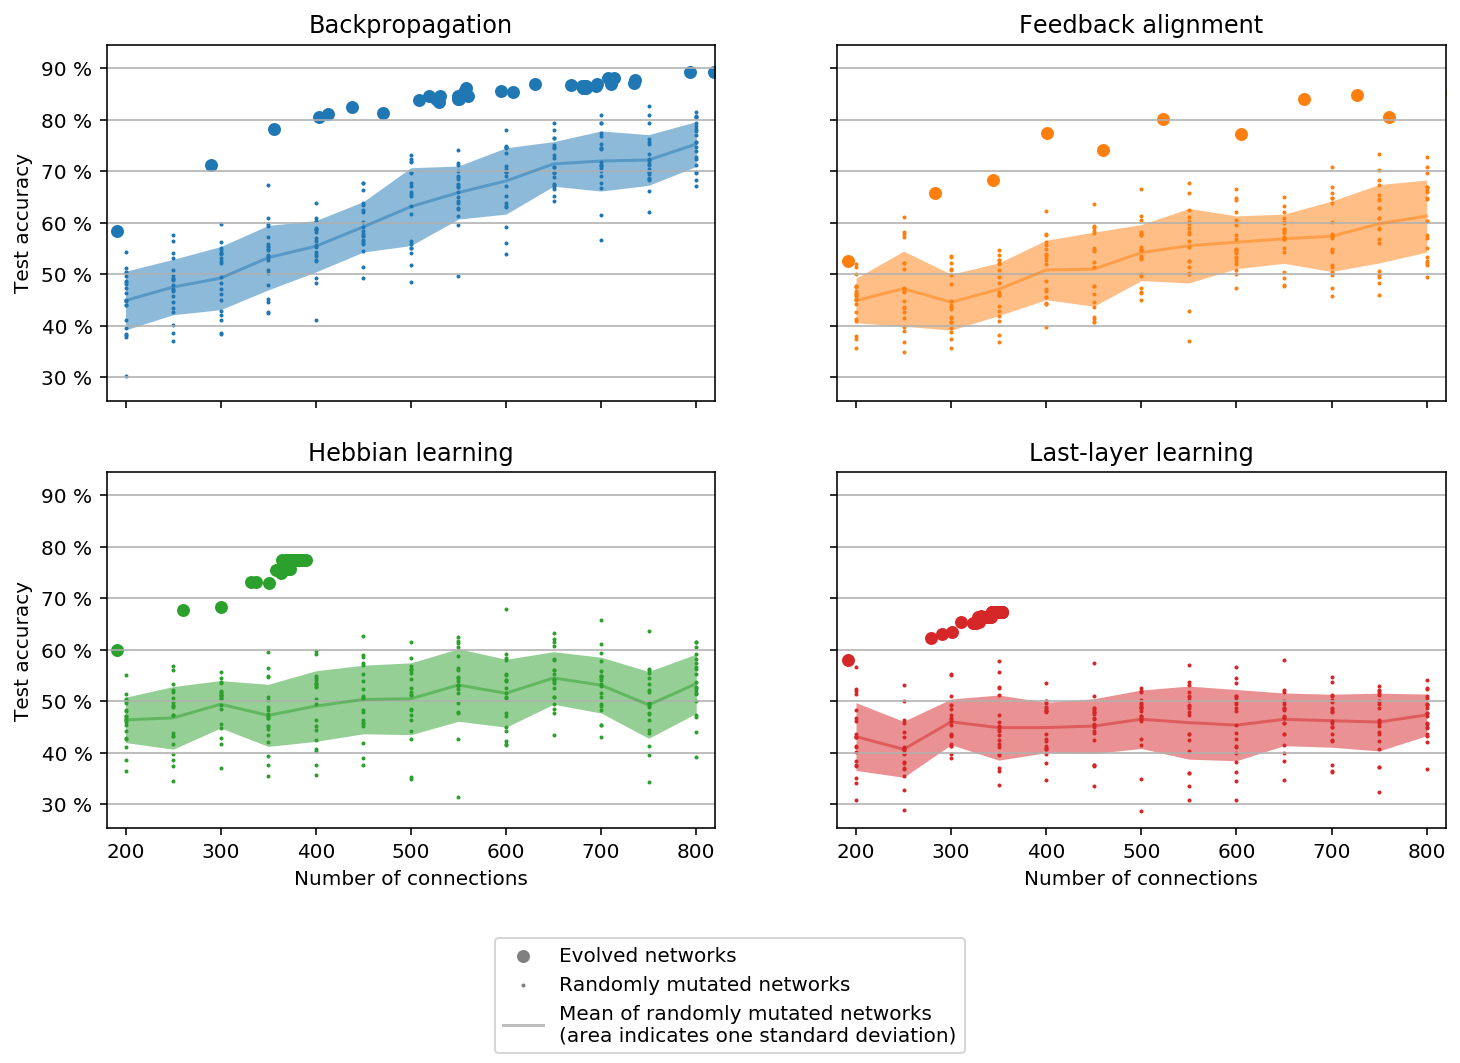

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)

for ax, key in zip(axes.flatten(), df_dict):
    plt.sca(ax)
    plt.title(label_dict[key])
    plt.gca().yaxis.grid(True)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0, symbol=' %'))

    
    # Plot evolved networks.
    # TODO: Use champion/connections here. 
    plt.scatter(df_dict[key]['stats/connections_mean'], df_dict[key]['champion/test_acc'], 
                s=30, color=color_dict[key], label='Evolved networks')
    
    # Plot some examples of randomly mutated networks (small circles).
    for i, accs in enumerate(randomly_mutated_network_accs_dict[key].T):
        plt.scatter(connection_values, accs, color=color_dict[key], s=1, 
                    label='Randomly mutated networks' if i==0 else None)
    
    # Plot mean (line) and standard deviation (area) of randomly mutated networks. 
    accs_mean = randomly_mutated_network_accs_dict[key].mean(1)
    accs_std = randomly_mutated_network_accs_dict[key].std(1)
    plt.fill_between(connection_values, 
                     accs_mean - accs_std, 
                     accs_mean + accs_std,
                     alpha=0.5, color=color_dict[key], linewidth=0)
    plt.plot(connection_values, accs_mean, color_dict[key], alpha=0.5,
            label='Mean of randomly mutated networks\n(area indicates one standard deviation)')
    
    #plt.xlim(180, df_dict[key]['stats/connections_mean'].max()*1.03)
    plt.xlim(180, 820)
    
    
subplots_xlabel(axes, 'Number of connections')
subplots_ylabel(axes, 'Test accuracy')

# Make figure legend.
handles, labels = plt.gca().get_legend_handles_labels()
for i in range(len(handles)):
    handles[i] = copy.copy(handles[i])  # without this, it changes the color in the plot as well
    handles[i].set_color('grey')
    
order = [1, 2, 0]
fig.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower center')

plt.subplots_adjust(hspace=0.2, bottom=0.2)
#plt.savefig('figures/randomly-mutated.png', dpi=300)

## Learning curves of the inner loop

In [217]:
generations = [0, 100, 500]
population_size = 180
num_nets = 18

learning_curves_dict = {}

for key in out_dir_dict:
    
    print(f'Training networks for {key}:')
    learning_curves_dict[key] = np.zeros((len(generations), num_nets, params_dict[key]['num_epochs']))

    for i, generation in enumerate(tqdm_notebook(generations, desc='Generation')):
        for j, net_index in enumerate(tqdm_notebook(
            np.random.randint(0, population_size, num_nets), desc='Network', leave=False)):

            # Load network from json.
            net = WeightLearningNetwork.load(os.path.join(out_dir_dict[key], 'networks', 
                                                          f'generation{generation}-net{net_index}.json'))

            # Train it.
            net.reset_weights()
            net.create_torch_layers()
            _, batch_accs = train(net, train_dataset, params_dict[key])

            # Store accuracy for each epoch.
            epoch_accs = np.mean(batch_accs, 1)
            learning_curves_dict[key][i, j, :] = epoch_accs

Training networks for backprop:


Training networks for feedback_alignment:


Training networks for hebbian:


Training networks for last_layer:


In [218]:
# Store as json.
with open('learning_curves.json', 'w') as f:
    json.dump({
        'generations': generations, 
        'learning_curves_dict': {key: arr.tolist() for key, arr 
                                 in learning_curves_dict.items()}
    }, f)

In [ ]:
# Load from json.
with open('learning_curves.json', 'r') as f:
    j = json.load(f)
    generations = j['generations']
    learning_curves_dict = {key: np.array(value) for key, value 
                            in j['learning_curves_dict'].items()}
    
generations, learning_curves_dict

In [ ]:
linebreak_labels_dict = {
    'backprop': 'Backpropagation',
    'feedback_alignment': 'Feedback\nalignment'
}

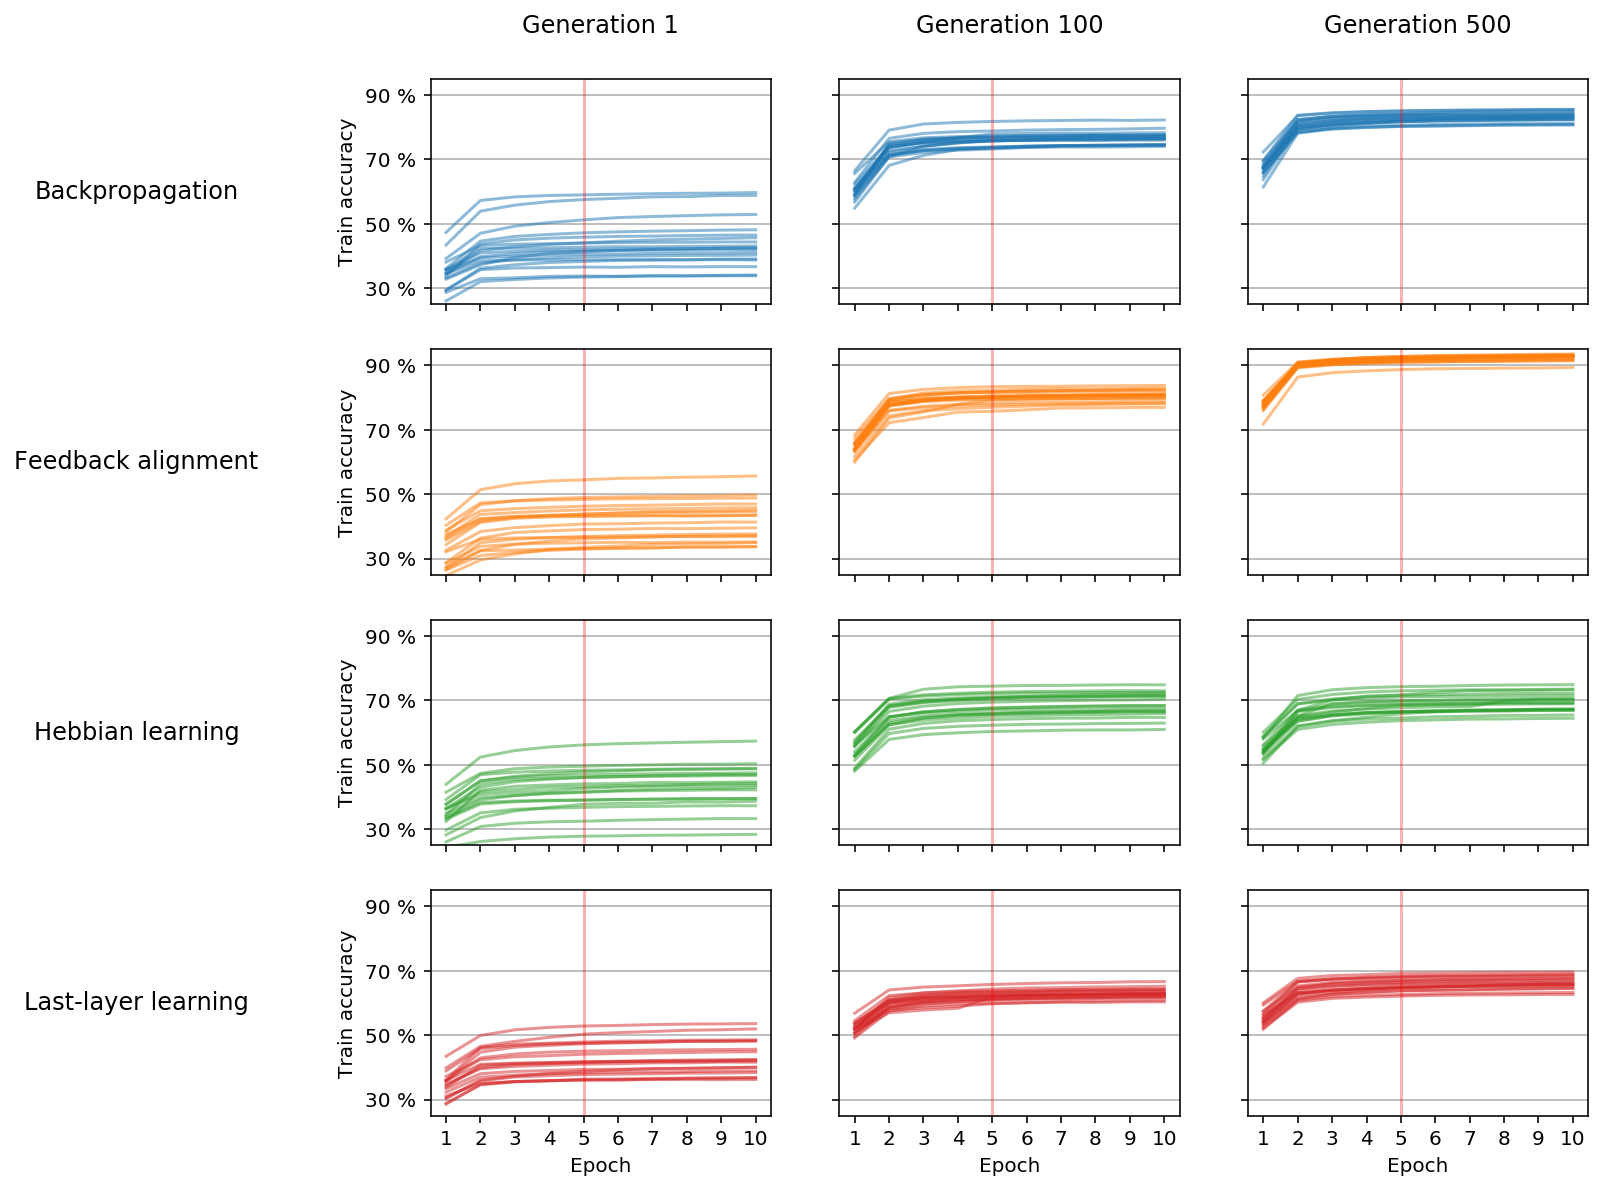

In [220]:
fig, axes = plt.subplots(4, len(generations), figsize=(12, 9), sharex=True, sharey=True)

#for row, (axes_row, learning_algorithm, df) in enumerate(zip(axes, learning_algorithms, dfs)):
for row, (axes_row, (key, learning_curves_per_generation)) in enumerate(zip(
    axes, learning_curves_dict.items())):
    
    for col, (ax, generation, learning_curves) in enumerate(zip(
        axes_row, generations, learning_curves_per_generation)):

        plt.sca(ax)

        if row == 0:  # first row
            plt.title(f'Generation {generation if generation != 0 else 1}', y=1.15, fontsize=12)
        #if row == len(axes) - 1:  # last row
        #plt.xlabel('Epoch')
        #if row < len(axes) - 1:  # all except last row
        #    plt.tick_params(bottom=False, labelbottom=False)

        plt.gca().yaxis.grid(True)
        plt.gca().yaxis.set_ticks([0.3, 0.5, 0.7, 0.9])
        plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0, symbol=' %'))
        plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=1))
        plt.ylim(0.25, 0.95)

        if col == 0:  # first col
            plt.text(-8, 0.6, label_dict[key], ha='center', va='center', fontsize=12)
            #plt.ylabel('Train accuracy')
        #if col > 0:  # all except first col
        #    plt.tick_params(left=False, labelleft=False)

        for learning_curve in learning_curves:
            plt.plot(range(1, len(learning_curve)+1), learning_curve, color=color_dict[key], alpha=0.5)
            
        plt.axvline(5, color='red', alpha=0.3)
        
subplots_xlabel(axes, 'Epoch')
subplots_ylabel(axes, 'Train accuracy')

plt.subplots_adjust(left=0.28, right=0.95, bottom=0.1, top=0.9)

#plt.savefig('figures/learning-curves.png', dpi=300)

## Architectures

In [141]:
def flatten(l):
    """Flatten a list of lists."""
    return [item for sublist in l for item in sublist]

def calculate_in_degrees(net, only_hidden=False):
    in_degrees = np.zeros(net.num_neurons)
    for from_neuron, to_neuron in net.connections:
        in_degrees[to_neuron] += 1
    if only_hidden:
        in_degrees = in_degrees[flatten(net.neurons_in_layer[1:-1])]
    return in_degrees

def calculate_out_degrees(net, only_hidden=False):
    out_degrees = np.zeros(net.num_neurons)
    for from_neuron, to_neuron in net.connections:
        out_degrees[from_neuron] += 1
    if only_hidden:
        out_degrees = out_degrees[flatten(net.neurons_in_layer[1:-1])]
    return out_degrees

def calculate_degrees(net, only_hidden=False):
    return calculate_in_degrees(net, only_hidden=only_hidden) + calculate_out_degrees(
        net, only_hidden=only_hidden)

#net = population_dict['backprop'][0]
#len(calculate_in_degrees(net)), len(calculate_in_degrees(net, only_hidden=True))

In [143]:
generation = 500
population_size = 180

# Load all networks for the given generation.
population_dict = {}
for key, out_dir in out_dir_dict.items():
    population = []
    for i in range(population_size):
        net = WeightLearningNetwork.load(os.path.join(out_dir, 'networks', 
                                                      f'generation{generation}-net{i}.json'))
        population.append(net)
    population_dict[key] = population

In [144]:
for key, population in population_dict.items():
    
    print(key)
    
    # Print number of connections, neurons, layers, averaged over population.
    connections = [net.get_num_connections() for net in population]
    print(f'Connections: {np.mean(connections):.3f} +- {np.std(connections):.3f}')

    neurons = [net.num_neurons for net in population]
    print(f'Neurons: {np.mean(neurons):.3f} +- {np.std(neurons):.3f}')

    layers = [len(net.neurons_in_layer) for net in population]
    print(f'Layers: {np.mean(layers):.3f} +- {np.std(layers):.3f}')
    
    
    # Print average in-degree, out-degree, degree, averaged over population.
    all_in_degrees = np.concatenate([calculate_in_degrees(net) for net in population])
    print(f'In-degree: {np.mean(all_in_degrees):.3f} +- {np.std(all_in_degrees):.3f}')

    all_out_degrees = np.concatenate([calculate_out_degrees(net) for net in population])
    print(f'Out-degree: {np.mean(all_out_degrees):.3f} +- {np.std(all_out_degrees):.3f}')

    all_degrees = np.concatenate([calculate_degrees(net) for net in population])
    print(f'Degree: {np.mean(all_degrees):.3f} +- {np.std(all_degrees):.3f}')
    
    print()

backprop
Connections: 684.583 +- 7.346
Neurons: 425.750 +- 1.986
Layers: 14.978 +- 0.738
In-degree: 1.608 +- 3.000
Out-degree: 1.608 +- 1.094
Degree: 3.216 +- 3.081

feedback_alignment
Connections: 1739.750 +- 6.198
Neurons: 566.222 +- 4.074
Layers: 19.061 +- 0.240
In-degree: 3.073 +- 4.671
Out-degree: 3.073 +- 1.946
Degree: 6.145 +- 4.930

hebbian
Connections: 371.083 +- 18.984
Neurons: 353.406 +- 3.181
Layers: 8.572 +- 0.587
In-degree: 1.050 +- 2.631
Out-degree: 1.050 +- 0.920
Degree: 2.100 +- 2.709

last_layer
Connections: 340.917 +- 7.100
Neurons: 356.778 +- 1.756
Layers: 6.072 +- 0.259
In-degree: 0.956 +- 2.799
Out-degree: 0.956 +- 0.837
Degree: 1.911 +- 2.841



Max: 21.0
Max: 30.0
Max: 18.0
Max: 23.0


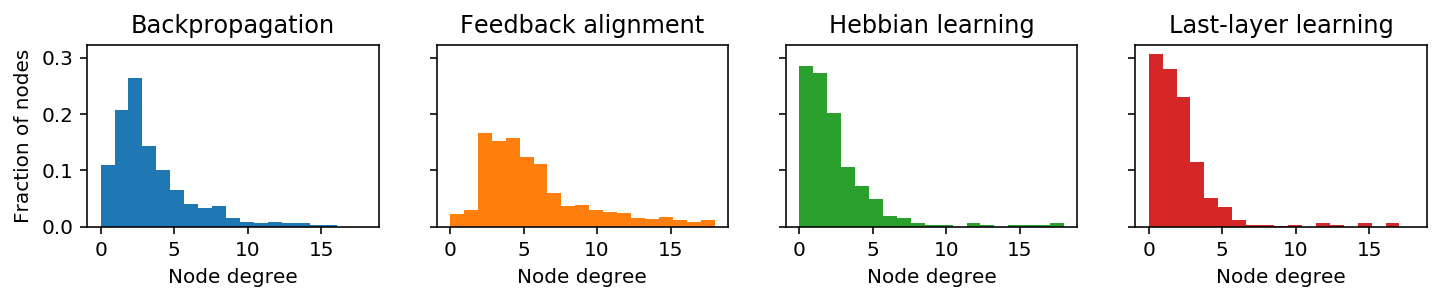

In [145]:
fig, axes = plt.subplots(1, 4, figsize=(12, 2), sharex=True, sharey=True)

bins = np.linspace(0, 18, 20)

for ax, (key, population) in zip(axes.flatten(), population_dict.items()):
    plt.sca(ax)
    plt.title(label_dict[key])
    
    # Calculate degrees for all nodes in all networks. 
    all_degrees = np.concatenate([calculate_degrees(net) for net in population])
    print('Max:', max(all_degrees))
    
    # Plot normalized histogram across degrees from all nodes in all networks. 
    plt.hist(all_degrees, bins, density=True, color=color_dict[key])
    
subplots_xlabel(axes, 'Node degree', is_row=True)
subplots_ylabel(axes, 'Fraction of nodes', is_row=True)

plt.subplots_adjust(bottom=0.25)
#plt.savefig('figures/node-degrees.png', dpi=300)